# WORKFLOW 1

#### Load test GCP-Functions: OPTIMIZED and BASELINE

In [1]:
!((cd ../loadtesting/test-function-optimized && k6 run script.js) & (cd ../loadtesting/test-function-baseline && k6 run script.js))


         /\      Grafana   /‾‾/  
    /\  /  \     |\  __   /  /   
   /  \/    \    | |/ /  /   ‾‾\ 
  /          \   |   (  |  (‾)  |
 / __________ \  |_|\_\  \_____/ 


         /\      Grafana   /‾‾/  
    /\  /  \     |\  __   /  /   
   /  \/    \    | |/ /  /   ‾‾\ 
  /          \   |   (  |  (‾)  |
 / __________ \  |_|\_\  \_____/ 

     execution: local
        script: script.js
        output: -

     scenarios: (100.00%) 1 scenario, 3 max VUs, 2m30s max duration (incl. graceful stop):
              * default: 3 looping VUs for 2m0s (gracefulStop: 30s)

     execution: local
        script: script.js
        output: -

     scenarios: (100.00%) 1 scenario, 3 max VUs, 2m30s max duration (incl. graceful stop):
              * default: 3 looping VUs for 2m0s (gracefulStop: 30s)

WARN[0000] Error from API server                         error="listen tcp 127.0.0.1:6565: bind: address already in use"

running (0m00.1s), 3/3 VUs, 0 complete and 0 interrupted iterations
default   [-

#### Import PYTHON modules

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("logs_fetch"))

from logs_fetch.logs_fetch import PROJECT_ID
from logs_fetch.logs_fetch import CloudFunction
from logs_fetch.logs_fetch import fetch_logs_and_save

from logs_metrics.calc_median import calc_median_OPTIMIZED
from logs_metrics.calc_median import calc_median_BASELINE

#### Fetch logs

In [3]:
fetch_logs_and_save(CloudFunction.OPTIMIZED, PROJECT_ID, 4)
fetch_logs_and_save(CloudFunction.BASELINE, PROJECT_ID, 4)

Analyzing logs for Cloud Function: optimizedFunction
Logs saved to ./logs_archive/2024-11-11-optimizedFunction-logs.csv

Analyzing logs for Cloud Function: baselineFunction
Logs saved to ./logs_archive/2024-11-11-baselineFunction-logs.csv



#### Calculate the median

In [4]:
calc_median_OPTIMIZED()
calc_median_BASELINE()

The median of OPTIMIZED function execution time is: 562.5
The median of BASELINE function execution time is: 608.0


### Seaborn

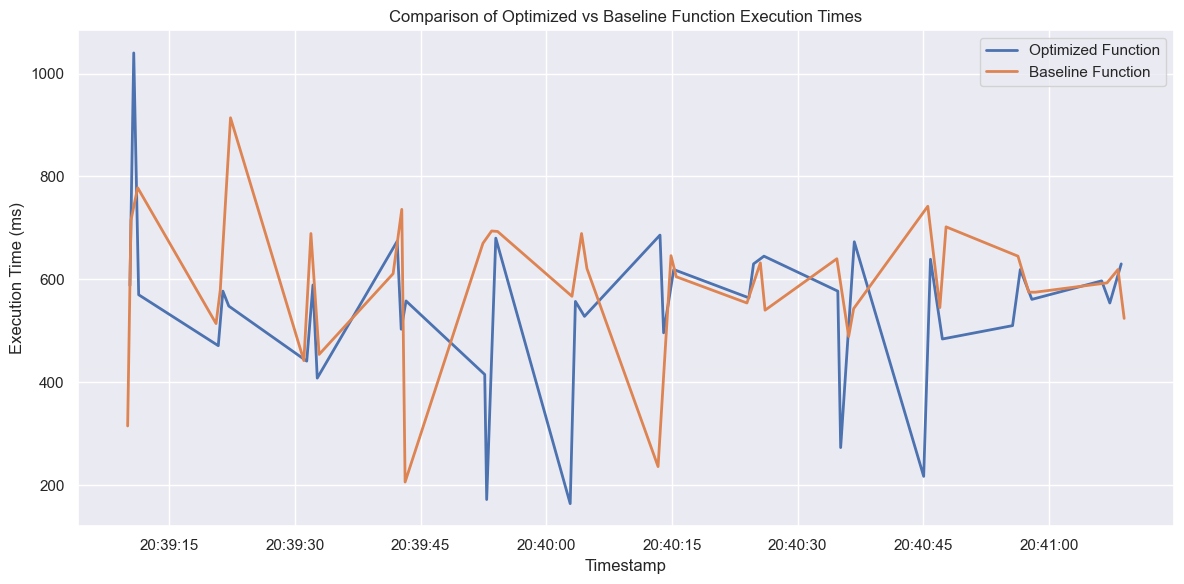

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Load data
today_date = datetime.now().strftime("%Y-%m-%d")

df_optimized = pd.read_csv(f"./logs_archive/{today_date}-optimizedFunction-logs.csv")
df_baseline = pd.read_csv(f"./logs_archive/{today_date}-baselineFunction-logs.csv")

# Convert 'timestamp' column to datetime
df_optimized['timestamp'] = pd.to_datetime(df_optimized['timestamp'])
df_baseline['timestamp'] = pd.to_datetime(df_baseline['timestamp'])

sns.set_theme(style="darkgrid")  # Options: darkgrid, whitegrid, dark, white, ticks
palette = sns.color_palette("deep")  # Options: "Set1", "Set2", "Set3", "coolwarm", "viridis", etc.

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time
sns.lineplot(data=df_optimized, x='timestamp', y='execution_time', color=palette[0], label='Optimized Function', lw=2)

# Plot baseline function execution time
sns.lineplot(data=df_baseline, x='timestamp', y='execution_time', color=palette[1], label='Baseline Function', lw=2)

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Execution Time (ms)')
plt.title('Comparison of Optimized vs Baseline Function Execution Times')

# Add a legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show() 

#### Y-axis from 0

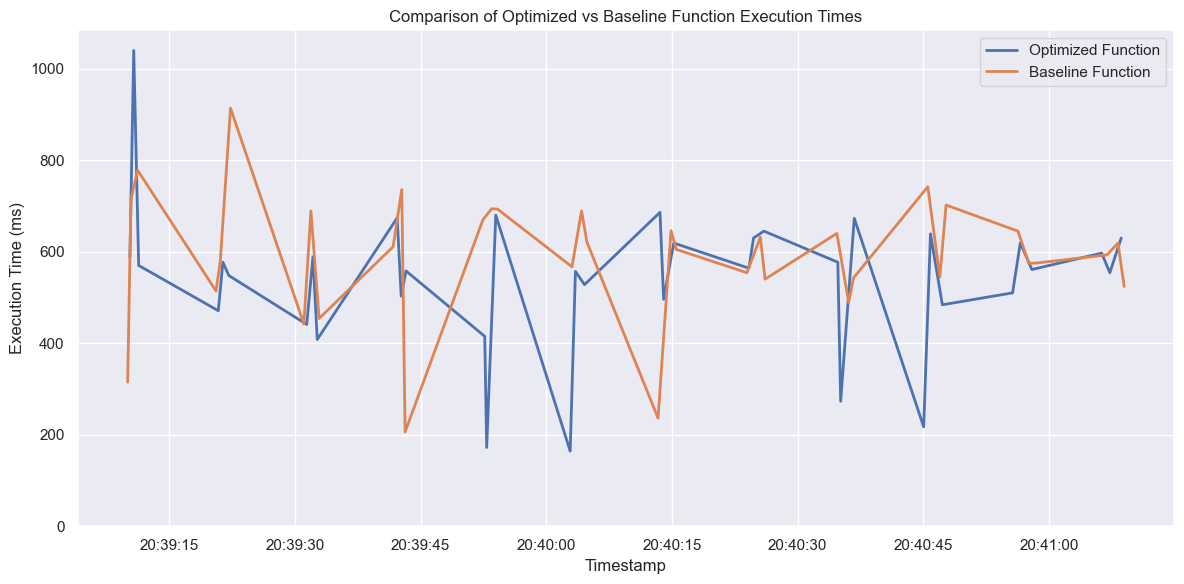

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Load data
today_date = datetime.now().strftime("%Y-%m-%d")

df_optimized = pd.read_csv(f"./logs_archive/{today_date}-optimizedFunction-logs.csv")
df_baseline = pd.read_csv(f"./logs_archive/{today_date}-baselineFunction-logs.csv")

# Convert 'timestamp' column to datetime
df_optimized['timestamp'] = pd.to_datetime(df_optimized['timestamp'])
df_baseline['timestamp'] = pd.to_datetime(df_baseline['timestamp'])

sns.set_theme(style="darkgrid")  # Options: darkgrid, whitegrid, dark, white, ticks
palette = sns.color_palette("deep")  # Options: "Set1", "Set2", "Set3", "coolwarm", "viridis", etc.

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time
sns.lineplot(data=df_optimized, x='timestamp', y='execution_time', color=palette[0], label='Optimized Function', lw=2)

# Plot baseline function execution time
sns.lineplot(data=df_baseline, x='timestamp', y='execution_time', color=palette[1], label='Baseline Function', lw=2)

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Execution Time (ms)')
plt.title('Comparison of Optimized vs Baseline Function Execution Times')

# Set y-axis to start from 0
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()